In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import plotly.graph_objects as go
import numpy as np

# Проверка наличия GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Определение модели с классическим max pooling
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Добавлен расчет размерности выходного тензора
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Используем размер для CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        self.pool = nn.MaxPool2d(2, 2)  # Используем max pooling с ядром 2x2

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Используем flatten для динамического вычисления размерности
        x = torch.flatten(x, 1)  # flatten все, кроме первой размерности (batch size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Определение модели с тропическим max pooling
class TropicalMaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):  # Ядро 2x2 и шаг 2
        super(TropicalMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = nn.Parameter(torch.randn(kernel_size, kernel_size) * 0.01)

    def forward(self, x):
        # Сначала добавляем обучаемые слагаемые к входам
        batch_size, channels, height, width = x.size()
        x_padded = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        out_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1

        output = torch.zeros(batch_size, channels, out_height, out_width).to(x.device)

        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.stride
                w_start = j * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                region = x_padded[:, :, h_start:h_end, w_start:w_end]

                # Добавление обучаемых слагаемых
                region_with_bias = region + self.weights
                output[:, :, i, j] = region_with_bias.max(dim=2)[0].max(dim=2)[0]

        return output

class TropicalConvNet(nn.Module):
    def __init__(self):
        super(TropicalConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Добавлен расчет размерности выходного тензора
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Используем размер для CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        self.pool = TropicalMaxPool2d(kernel_size=2, stride=2)  # Используем тропическое max pooling с ядром 2x2

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Используем flatten для динамического вычисления размерности
        x = torch.flatten(x, 1)  # flatten все, кроме первой размерности (batch size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Загрузка данных CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Инициализация моделей
model_classic = ConvNet().to(device)
model_tropical = TropicalConvNet().to(device)

# Критерий и оптимизаторы
criterion = nn.CrossEntropyLoss()
optimizer_classic = optim.Adam(model_classic.parameters(), lr=0.001)
optimizer_tropical = optim.Adam(model_tropical.parameters(), lr=0.001)

# Функция для обучения модели
def train_model(model, trainloader, criterion, optimizer, epochs=20):
    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Перемещаем данные на GPU
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_list.append(running_loss/len(trainloader))
        accuracy_list.append(100 * correct / total)

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}, Accuracy: {100 * correct / total}%")

    return loss_list, accuracy_list

# Обучаем обе модели
loss_classic, accuracy_classic = train_model(model_classic, trainloader, criterion, optimizer_classic)
loss_tropical, accuracy_tropical = train_model(model_tropical, trainloader, criterion, optimizer_tropical)

# Рассчитываем стандартное отклонение ошибки и точности для обеих моделей
def calculate_metrics(loss_list, accuracy_list):
    loss_std = np.std(loss_list)
    accuracy_std = np.std(accuracy_list)
    return loss_std, accuracy_std

loss_std_classic, accuracy_std_classic = calculate_metrics(loss_classic, accuracy_classic)
loss_std_tropical, accuracy_std_tropical = calculate_metrics(loss_tropical, accuracy_tropical)

# Печатаем результаты
print(f"Standard Deviation of Loss - Classic Model: {loss_std_classic}")
print(f"Standard Deviation of Accuracy - Classic Model: {accuracy_std_classic}")
print(f"Standard Deviation of Loss - Tropical Model: {loss_std_tropical}")
print(f"Standard Deviation of Accuracy - Tropical Model: {accuracy_std_tropical}")

# Построение графиков
fig = go.Figure()

# Добавляем графики потерь
fig.add_trace(go.Scatter(x=list(range(1, len(loss_classic) + 1)), y=loss_classic, mode='lines', name='Loss (Classic)'))
fig.add_trace(go.Scatter(x=list(range(1, len(loss_tropical) + 1)), y=loss_tropical, mode='lines', name='Loss (Tropical)'))

# Добавляем графики потерь
fig.add_trace(go.Scatter(x=list(range(1, len(loss_classic) + 1)), y=loss_classic, mode='lines', name='Loss (Classic)'))
fig.add_trace(go.Scatter(x=list(range(1, len(loss_tropical) + 1)), y=loss_tropical, mode='lines', name='Loss (Tropical)'))

# Добавляем графики точности
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_classic) + 1)), y=accuracy_classic, mode='lines', name='Accuracy (Classic)'))
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_tropical) + 1)), y=accuracy_tropical, mode='lines', name='Accuracy (Tropical)'))

# Настройки графика
fig.update_layout(
    title="Loss and Accuracy Comparison (Classic vs Tropical MaxPooling)",
    xaxis_title="Epoch",
    yaxis_title="Value",
    legend_title="Metrics",
    template="plotly_dark"
)

fig.show()

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.365130827326299, Accuracy: 50.368%
Epoch 2, Loss: 0.9303868131716843, Accuracy: 67.1%
Epoch 3, Loss: 0.749427382522227, Accuracy: 73.808%
Epoch 4, Loss: 0.629923010116343, Accuracy: 77.896%
Epoch 5, Loss: 0.5297151121984968, Accuracy: 81.554%
Epoch 6, Loss: 0.4452776988906324, Accuracy: 84.316%
Epoch 7, Loss: 0.36690487205753547, Accuracy: 87.088%
Epoch 8, Loss: 0.2928737157865254, Accuracy: 89.62%
Epoch 9, Loss: 0.23499136531482573, Accuracy: 91.702%
Epoch 10, Loss: 0.17934289725635516, Accuracy: 93.636%
Epoch 11, Loss: 0.15157381117420124, Accuracy: 94.606%
Epoch 12, Loss: 0.13257493714913918, Accuracy: 95.29%
Epoch 13, Loss: 0.10713977710513012, Accuracy: 96.246%
Epoch 14, Loss: 0.0878168690391123, Accuracy: 96.97%
Epoch 15, Loss: 0.0867935750756146, Accuracy: 96.962%
Epoch 16, Loss: 0.07977076695637678, Accuracy: 97.27%
Epoch 17, Loss: 0.07988000151914451, Accuracy: 97.20

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training Tropical Model:
Epoch 1, Loss: 1.3060667384463502, Accuracy: 52.762%


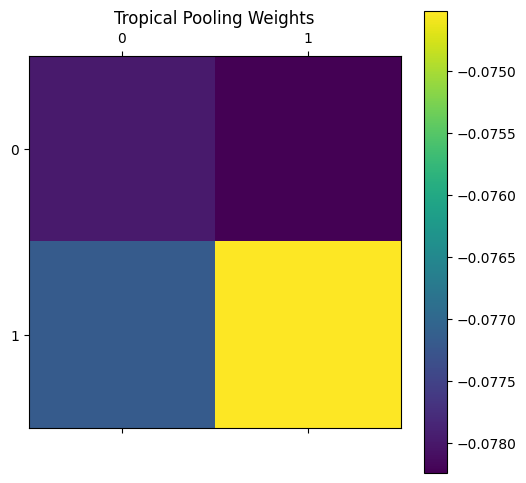

Epoch 2, Loss: 0.8364800067280259, Accuracy: 70.528%


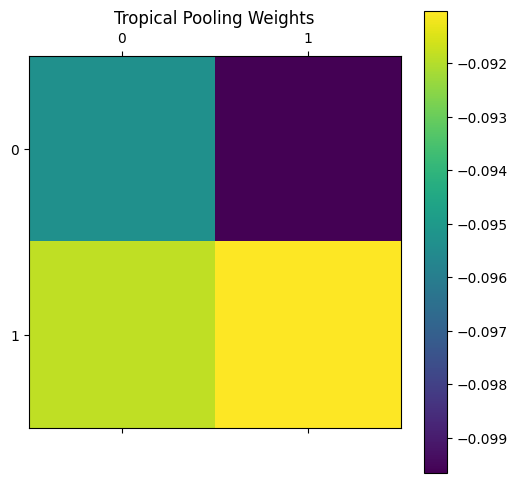

Epoch 3, Loss: 0.6436620105029373, Accuracy: 77.464%


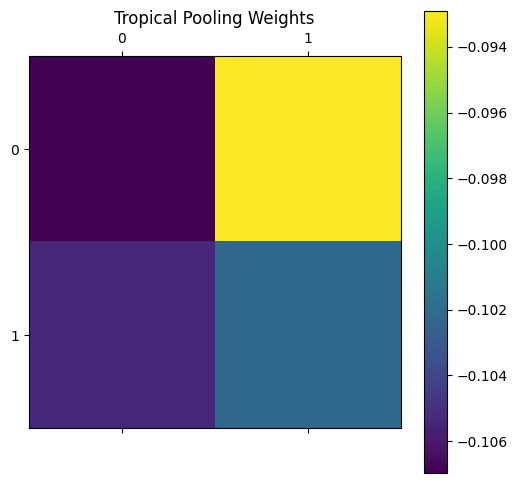

Epoch 4, Loss: 0.5021359404677626, Accuracy: 82.504%


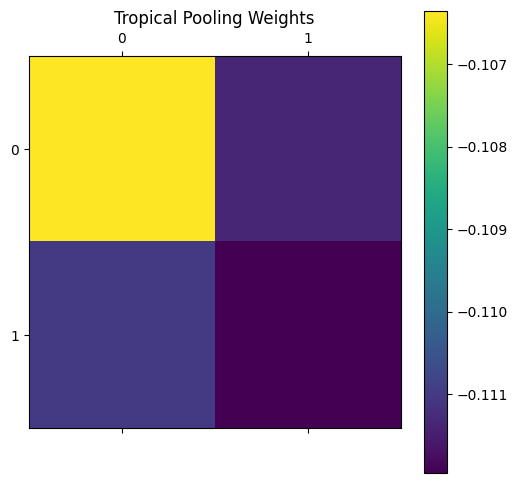

Epoch 5, Loss: 0.3768978275911278, Accuracy: 86.748%


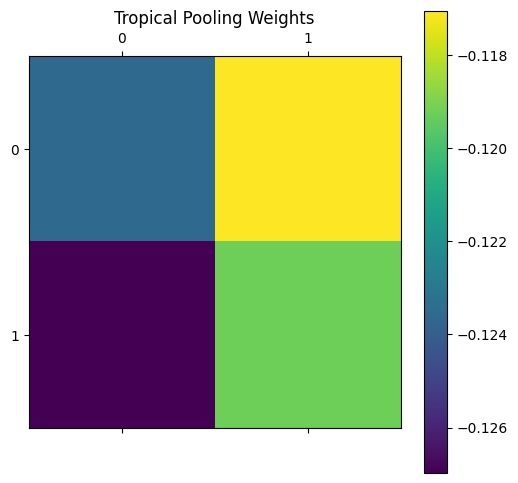

Epoch 6, Loss: 0.27412496113678075, Accuracy: 90.432%


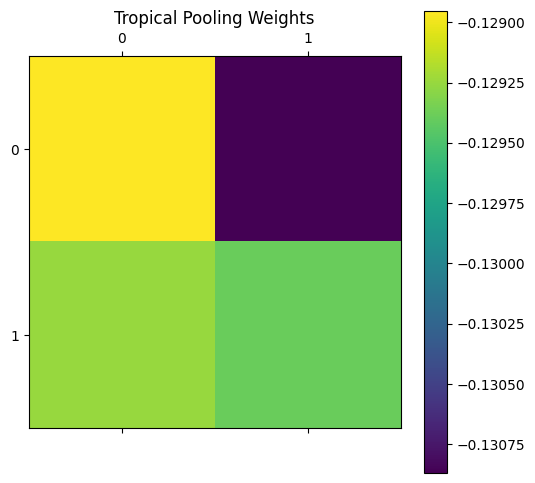

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define a CNN with classical max pooling
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2x2, stride 2

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Define a CNN with tropical max pooling
class TropicalMaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(TropicalMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Learnable weights for tropical multiplication (addition in tropical algebra)
        self.weights = nn.Parameter(torch.randn(kernel_size, kernel_size) * 0.01)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_padded = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        out_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1

        output = torch.zeros(batch_size, channels, out_height, out_width).to(x.device)

        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.stride
                w_start = j * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                region = x_padded[:, :, h_start:h_end, w_start:w_end]

                # Tropical multiplication: Add learnable weights (equivalent to multiplication in tropical algebra)
                region_with_weights = region + self.weights  # Element-wise addition

                # Tropical addition: Take the maximum (equivalent to addition in tropical algebra)
                output[:, :, i, j] = region_with_weights.max(dim=2)[0].max(dim=2)[0]

        return output

class TropicalConvNet(nn.Module):
    def __init__(self):
        super(TropicalConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Tropical max pooling layer
        self.pool = TropicalMaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

import matplotlib.pyplot as plt

# Функция для визуализации весов тропического пуллинга
def visualize_tropical_weights(model):
    # Извлекаем веса из слоя тропического пуллинга
    weights = model.pool.weights.detach().cpu().numpy()

    # Создаем график для визуализации весов
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(weights, cmap='viridis')
    fig.colorbar(cax)
    ax.set_title('Tropical Pooling Weights')
    plt.show()

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize models
model_classic = ConvNet().to(device)
model_tropical = TropicalConvNet().to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_classic = optim.Adam(model_classic.parameters(), lr=0.001)
optimizer_tropical = optim.Adam(model_tropical.parameters(), lr=0.001)

# Function to train the model
def train_model(model, trainloader, criterion, optimizer, epochs=20):
    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_list.append(running_loss / len(trainloader))
        accuracy_list.append(100 * correct / total)

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Accuracy: {100 * correct / total}%")
        visualize_tropical_weights(model)

    return loss_list, accuracy_list

# Function to evaluate the model on the test set
def evaluate_model(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}%")
    return test_loss, accuracy

# Train both models
# print("Training Classic Model:")
# loss_classic, accuracy_classic = train_model(model_classic, trainloader, criterion, optimizer_classic)

print("Training Tropical Model:")
loss_tropical, accuracy_tropical = train_model(model_tropical, trainloader, criterion, optimizer_tropical)

# Evaluate both models on the test set
# print("Evaluating Classic Model:")
# test_loss_classic, test_accuracy_classic = evaluate_model(model_classic, testloader, criterion)

print("Evaluating Tropical Model:")
test_loss_tropical, test_accuracy_tropical = evaluate_model(model_tropical, testloader, criterion)

# Plot training loss and accuracy
fig = make_subplots(rows=1, cols=2, subplot_titles=("Training Loss", "Training Accuracy"))

# Add loss plots
# fig.add_trace(go.Scatter(x=list(range(1, len(loss_classic) + 1)), y=loss_classic, mode='lines', name='Loss (Classic)'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_tropical) + 1)), y=loss_tropical, mode='lines', name='Loss (Tropical)'), row=1, col=1)

# Add accuracy plots
# fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_classic) + 1)), y=accuracy_classic, mode='lines', name='Accuracy (Classic)'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_tropical) + 1)), y=accuracy_tropical, mode='lines', name='Accuracy (Tropical)'), row=1, col=2)

# Update layout
fig.update_layout(
    title="Training Loss and Accuracy Comparison (Classic vs Tropical MaxPooling)",
    xaxis_title="Epoch",
    yaxis_title="Value",
    legend_title="Metrics",
    template="plotly_dark",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray')
)

fig.show()

## Попробуем раздельные веса тропического пуллинга для признаков и слоев.

Using device: cuda
Files already downloaded and verified
Epoch 1/20
Loss: 1.4754 | Accuracy: 46.01%


<Figure size 500x500 with 0 Axes>

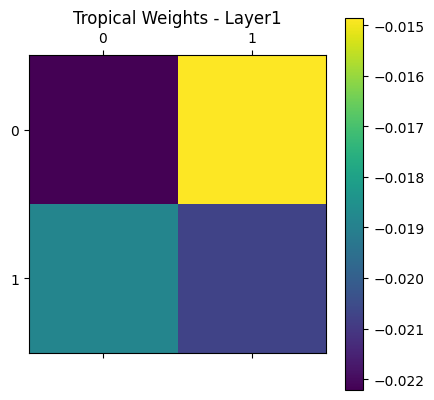

<Figure size 500x500 with 0 Axes>

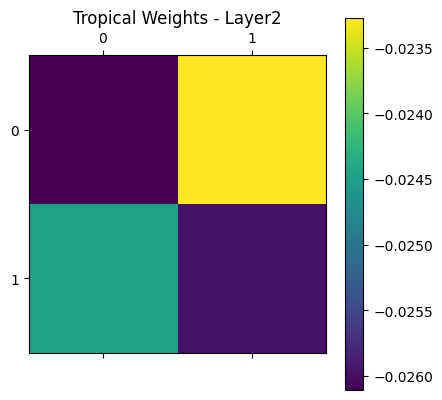

<Figure size 500x500 with 0 Axes>

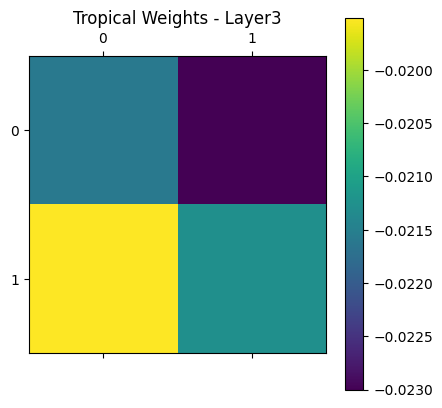

Epoch 2/20
Loss: 1.0226 | Accuracy: 63.86%


<Figure size 500x500 with 0 Axes>

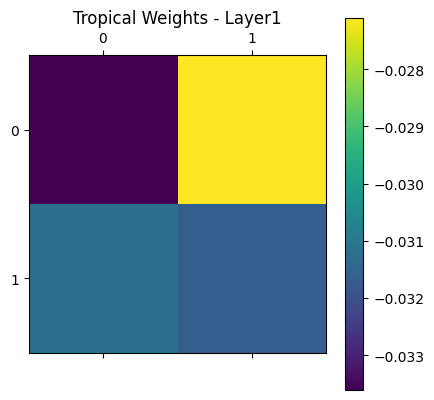

<Figure size 500x500 with 0 Axes>

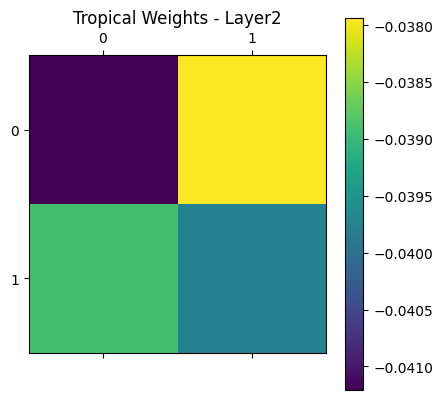

<Figure size 500x500 with 0 Axes>

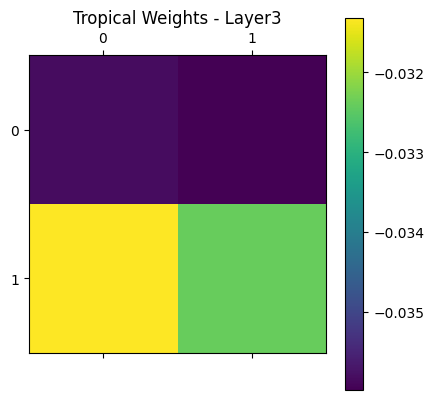

Epoch 3/20
Loss: 0.8228 | Accuracy: 71.13%


<Figure size 500x500 with 0 Axes>

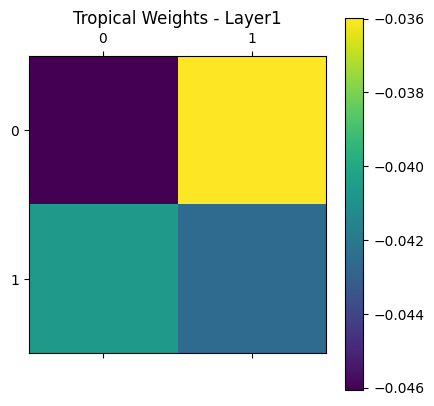

<Figure size 500x500 with 0 Axes>

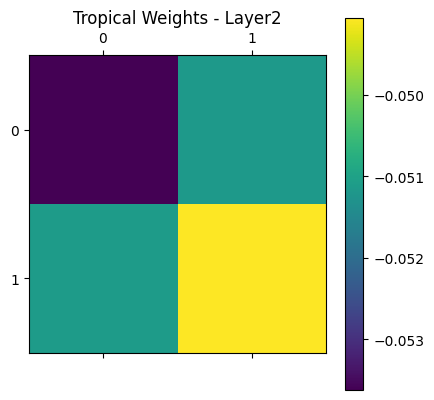

<Figure size 500x500 with 0 Axes>

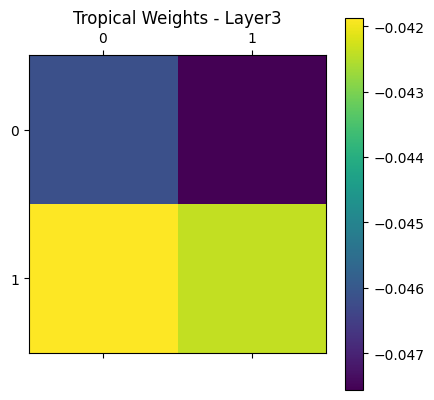

Epoch 4/20
Loss: 0.6934 | Accuracy: 75.80%


<Figure size 500x500 with 0 Axes>

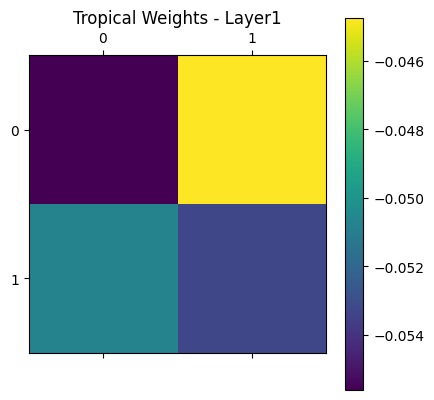

<Figure size 500x500 with 0 Axes>

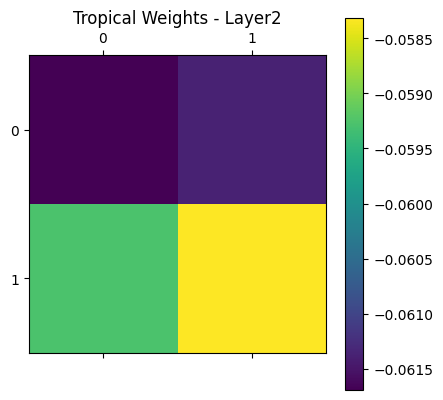

<Figure size 500x500 with 0 Axes>

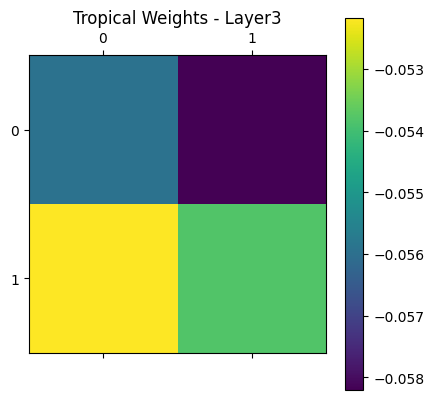

Epoch 5/20
Loss: 0.5898 | Accuracy: 79.38%


<Figure size 500x500 with 0 Axes>

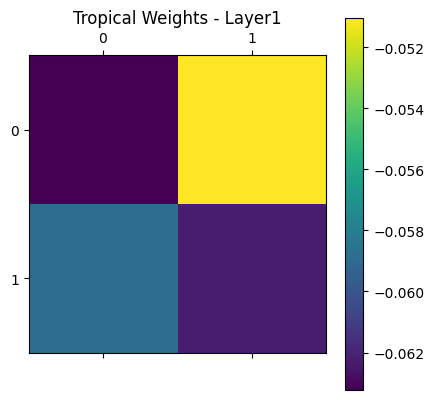

<Figure size 500x500 with 0 Axes>

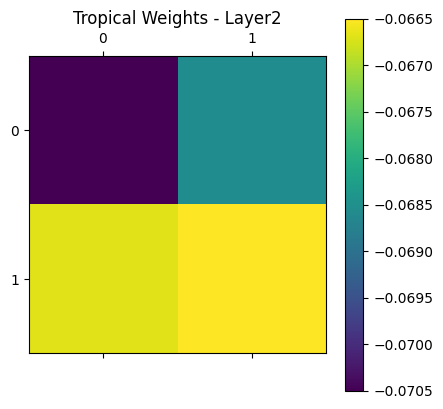

<Figure size 500x500 with 0 Axes>

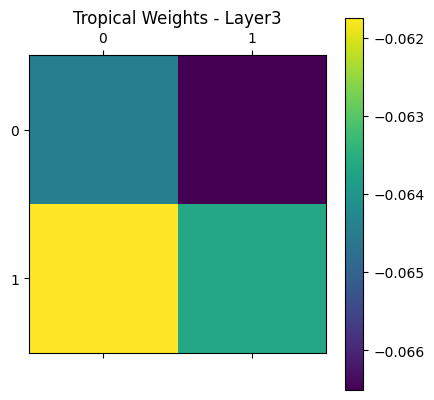

Epoch 6/20
Loss: 0.4983 | Accuracy: 82.46%


<Figure size 500x500 with 0 Axes>

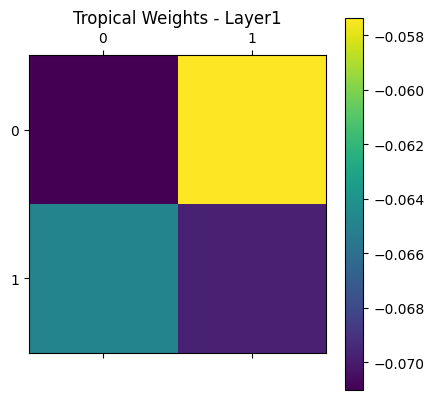

<Figure size 500x500 with 0 Axes>

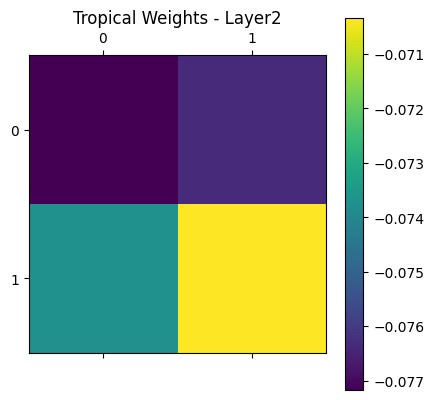

<Figure size 500x500 with 0 Axes>

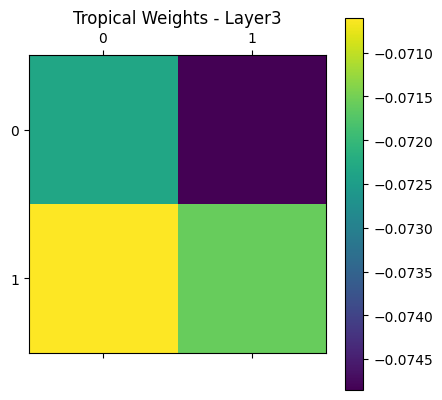

Epoch 7/20
Loss: 0.4138 | Accuracy: 85.55%


<Figure size 500x500 with 0 Axes>

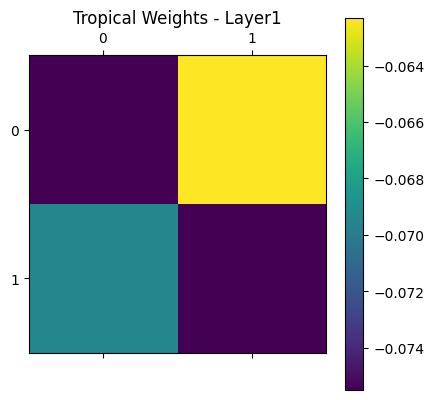

<Figure size 500x500 with 0 Axes>

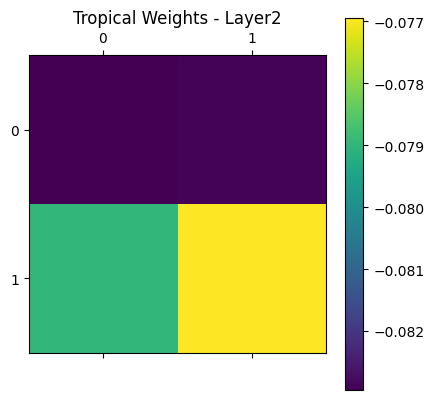

<Figure size 500x500 with 0 Axes>

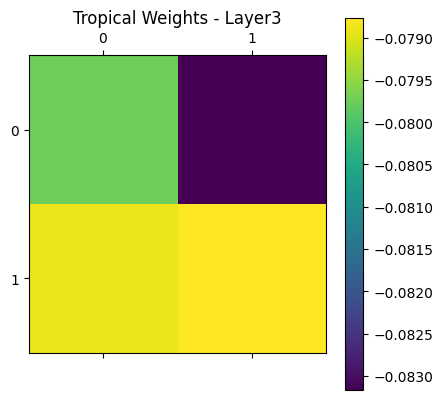

Epoch 8/20
Loss: 0.3430 | Accuracy: 87.90%


<Figure size 500x500 with 0 Axes>

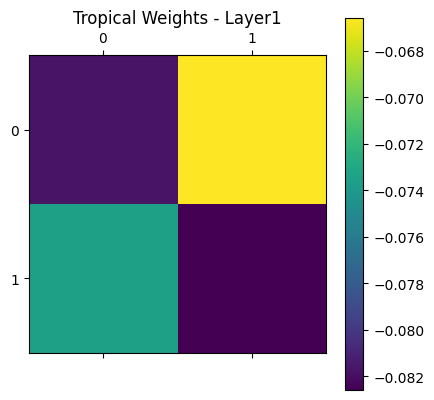

<Figure size 500x500 with 0 Axes>

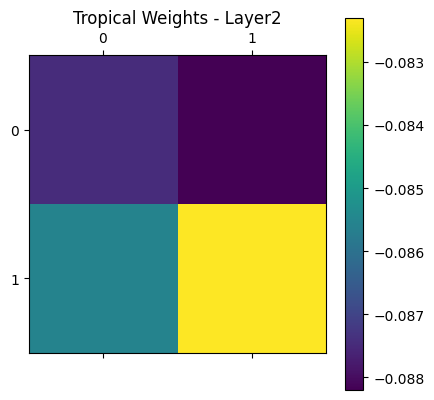

<Figure size 500x500 with 0 Axes>

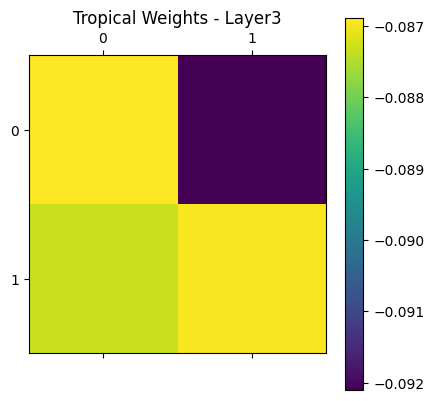

Epoch 9/20
Loss: 0.2675 | Accuracy: 90.82%


<Figure size 500x500 with 0 Axes>

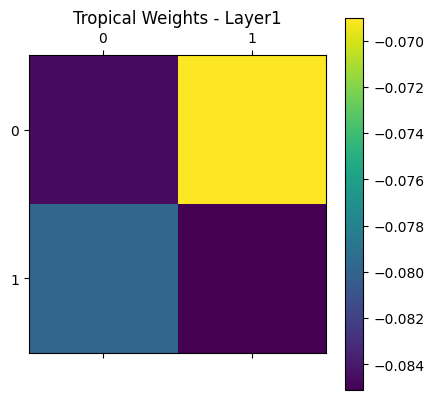

<Figure size 500x500 with 0 Axes>

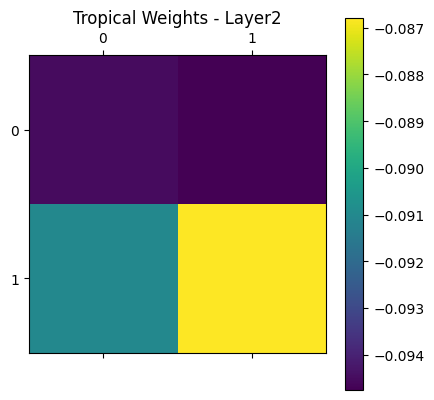

<Figure size 500x500 with 0 Axes>

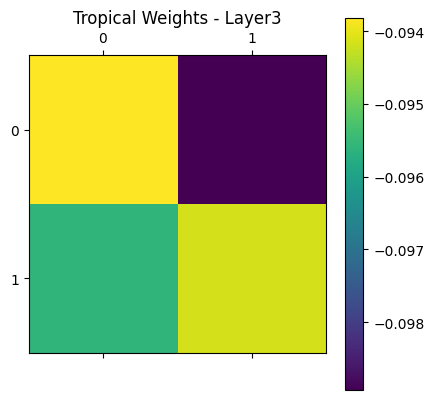

Epoch 10/20
Loss: 0.2091 | Accuracy: 92.75%


<Figure size 500x500 with 0 Axes>

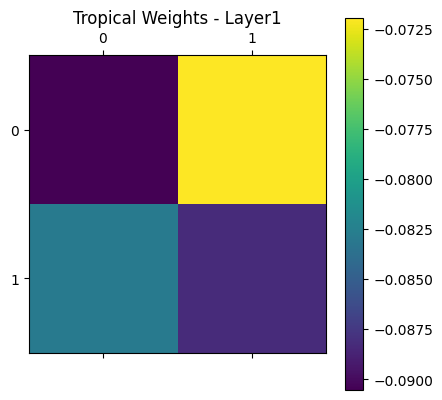

<Figure size 500x500 with 0 Axes>

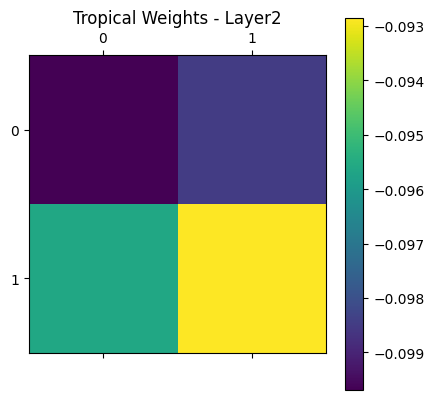

<Figure size 500x500 with 0 Axes>

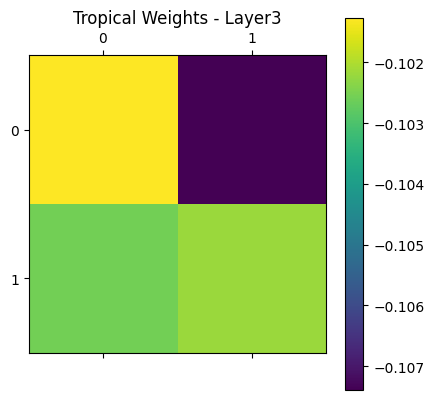

Epoch 11/20
Loss: 0.1525 | Accuracy: 94.89%


<Figure size 500x500 with 0 Axes>

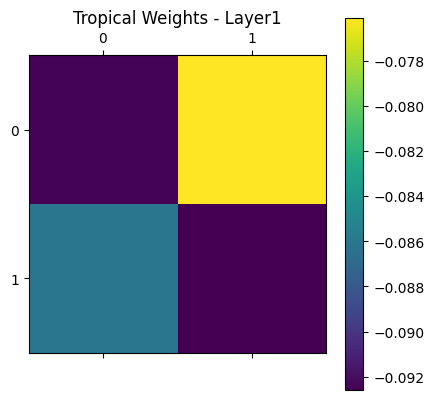

<Figure size 500x500 with 0 Axes>

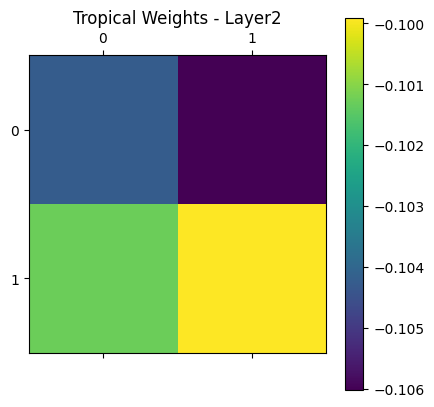

<Figure size 500x500 with 0 Axes>

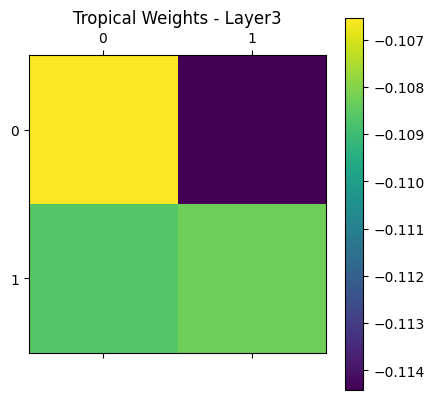

Epoch 12/20
Loss: 0.1200 | Accuracy: 95.95%


<Figure size 500x500 with 0 Axes>

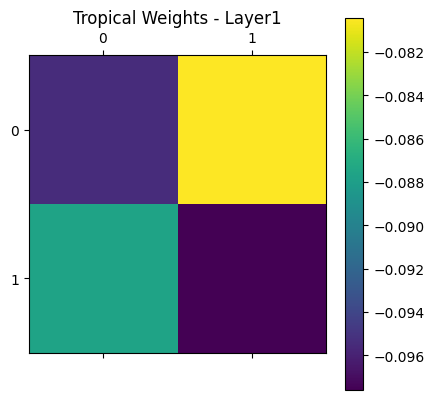

<Figure size 500x500 with 0 Axes>

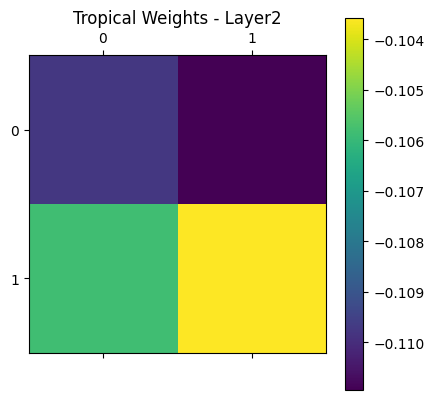

<Figure size 500x500 with 0 Axes>

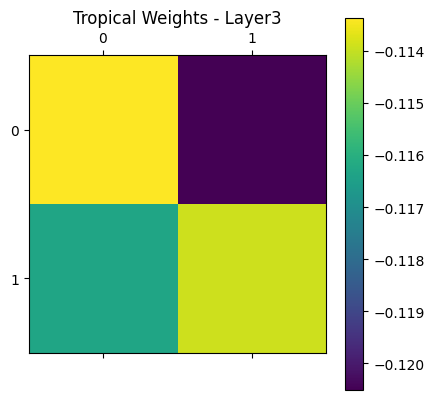

Epoch 13/20
Loss: 0.0855 | Accuracy: 97.16%


<Figure size 500x500 with 0 Axes>

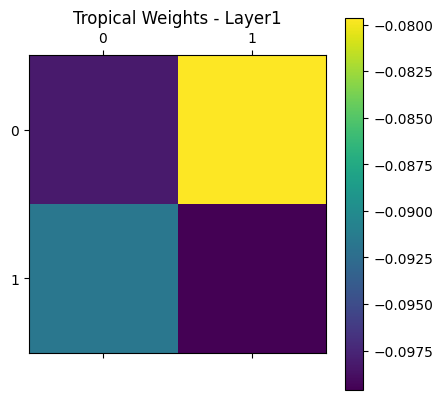

<Figure size 500x500 with 0 Axes>

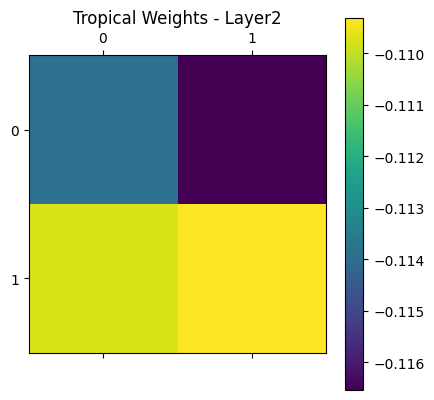

<Figure size 500x500 with 0 Axes>

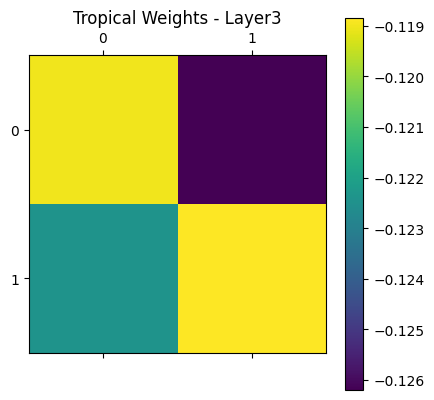

Epoch 14/20
Loss: 0.0772 | Accuracy: 97.37%


<Figure size 500x500 with 0 Axes>

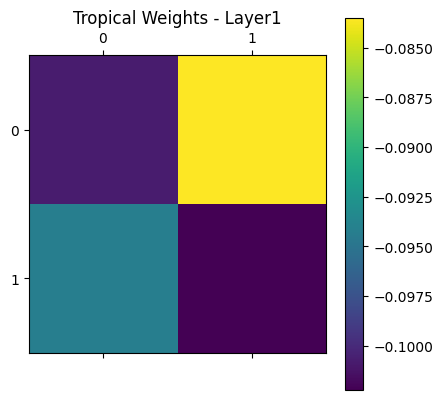

<Figure size 500x500 with 0 Axes>

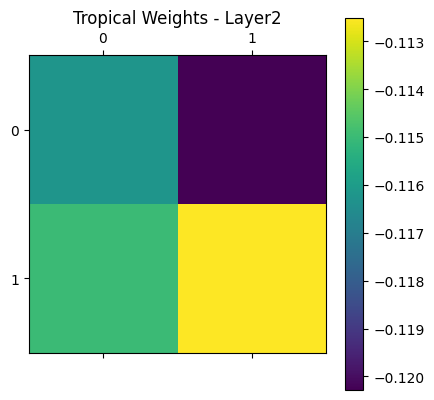

<Figure size 500x500 with 0 Axes>

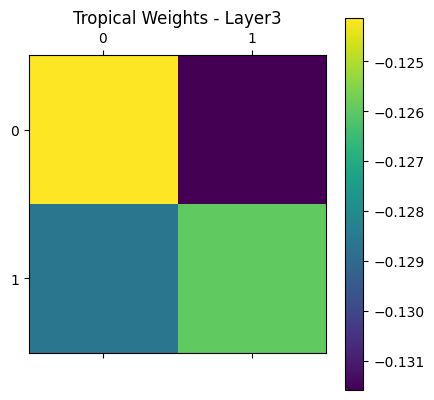

Epoch 15/20
Loss: 0.0668 | Accuracy: 97.71%


<Figure size 500x500 with 0 Axes>

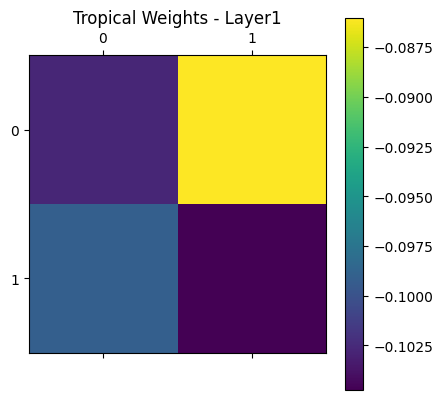

<Figure size 500x500 with 0 Axes>

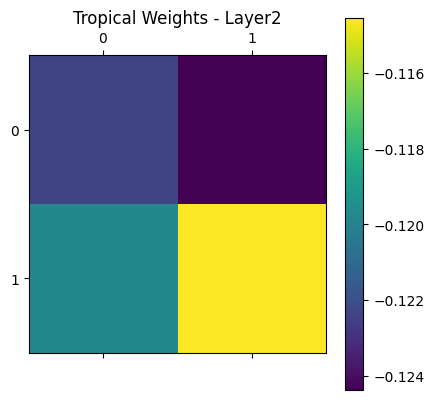

<Figure size 500x500 with 0 Axes>

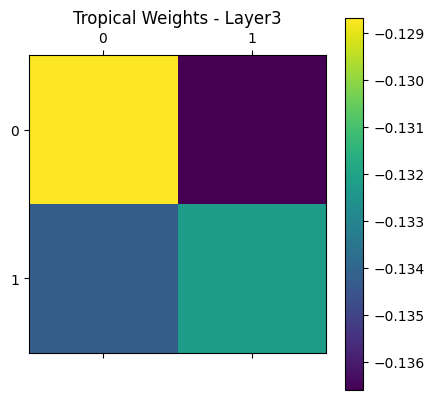

Epoch 16/20
Loss: 0.0630 | Accuracy: 97.80%


<Figure size 500x500 with 0 Axes>

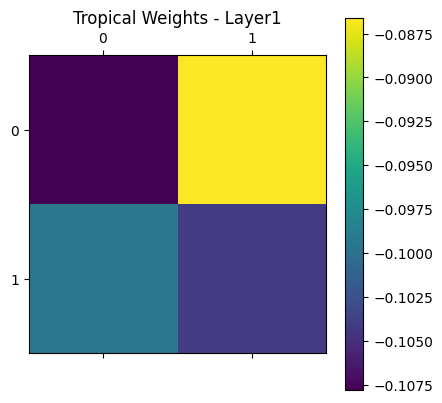

<Figure size 500x500 with 0 Axes>

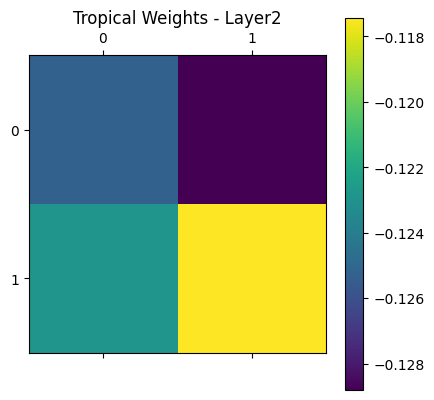

<Figure size 500x500 with 0 Axes>

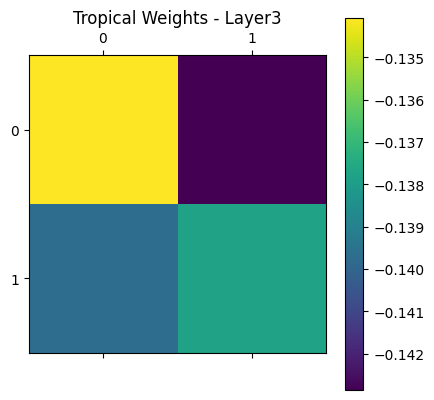

Epoch 17/20
Loss: 0.0546 | Accuracy: 98.10%


<Figure size 500x500 with 0 Axes>

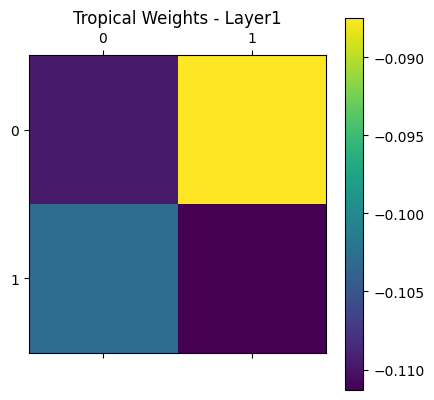

<Figure size 500x500 with 0 Axes>

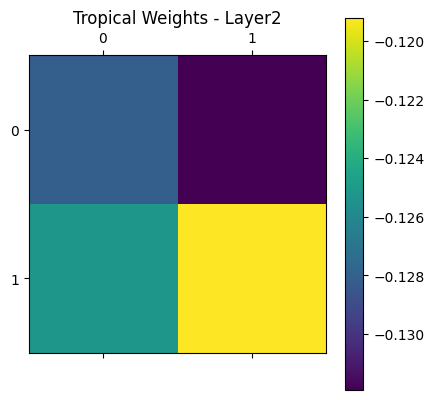

<Figure size 500x500 with 0 Axes>

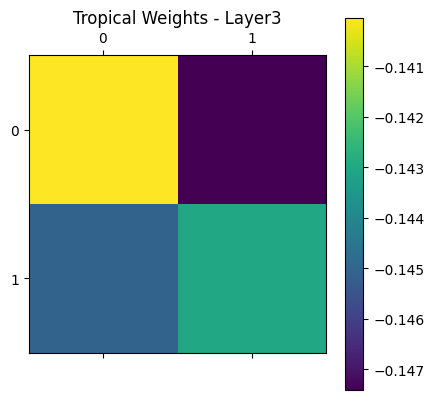

Epoch 18/20
Loss: 0.0494 | Accuracy: 98.27%


<Figure size 500x500 with 0 Axes>

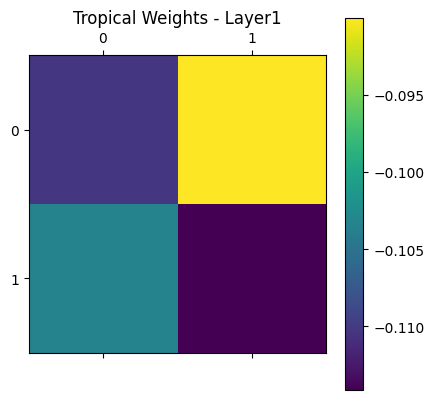

<Figure size 500x500 with 0 Axes>

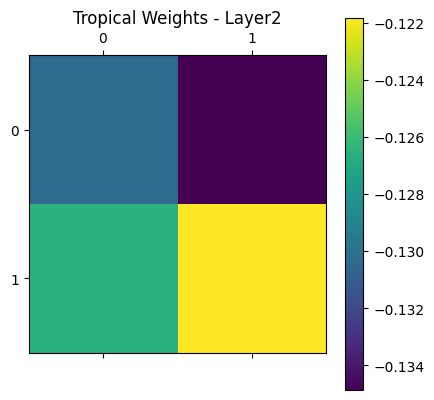

<Figure size 500x500 with 0 Axes>

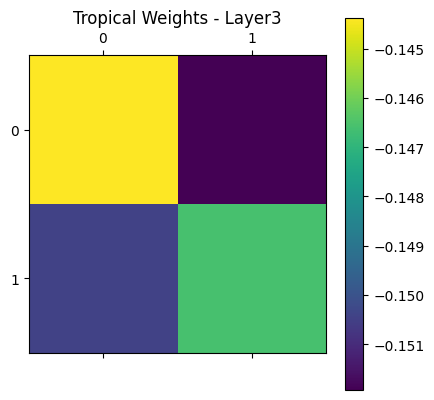

Epoch 19/20
Loss: 0.0656 | Accuracy: 97.72%


<Figure size 500x500 with 0 Axes>

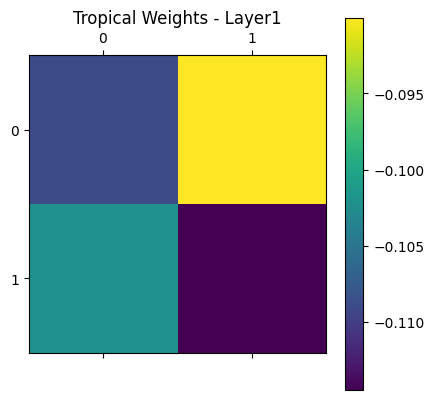

<Figure size 500x500 with 0 Axes>

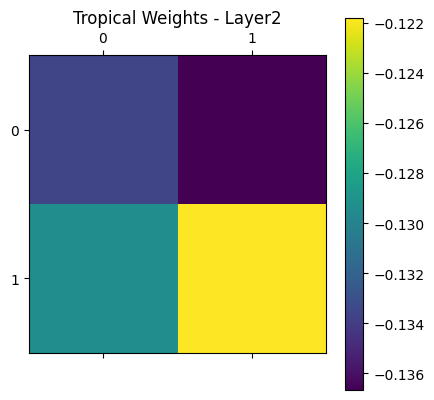

<Figure size 500x500 with 0 Axes>

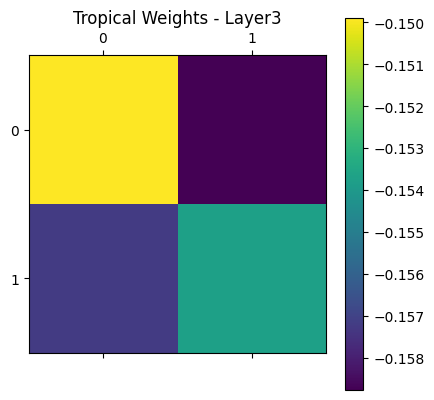

Epoch 20/20
Loss: 0.0415 | Accuracy: 98.55%


<Figure size 500x500 with 0 Axes>

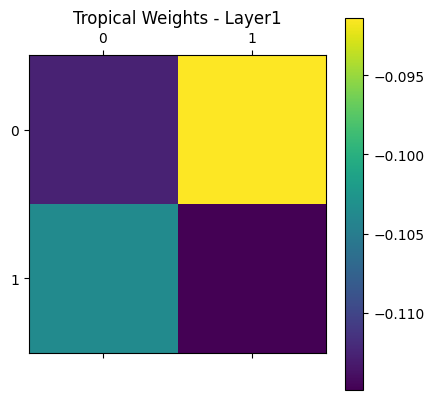

<Figure size 500x500 with 0 Axes>

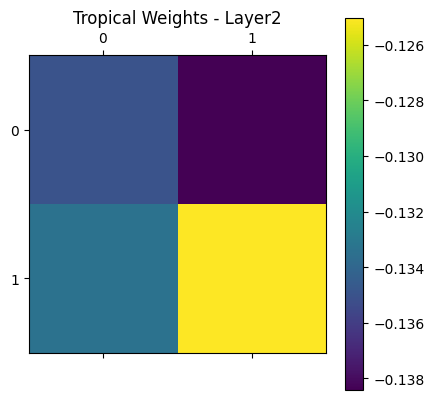

<Figure size 500x500 with 0 Axes>

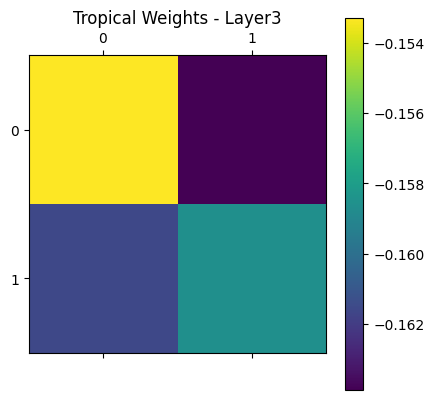

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class TropicalMaxPool2d(nn.Module):
    def __init__(self, channels, kernel_size=2, stride=2, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.channels = channels

        # Веса для каждого канала и элемента ядра
        self.weights = nn.Parameter(torch.randn(channels, kernel_size, kernel_size) * 0.01)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_padded = nn.functional.pad(x, (self.padding,)*4)

        out_h = (height - self.kernel_size + 2*self.padding) // self.stride + 1
        out_w = (width - self.kernel_size + 2*self.padding) // self.stride + 1

        output = torch.zeros(batch_size, channels, out_h, out_w).to(x.device)

        for i in range(out_h):
            for j in range(out_w):
                h_start = i * self.stride
                w_start = j * self.stride
                region = x_padded[:, :, h_start:h_start+self.kernel_size, w_start:w_start+self.kernel_size]

                # Добавляем веса для каждого канала
                weighted_region = region + self.weights.unsqueeze(0)
                output[:, :, i, j] = weighted_region.amax(dim=(3, 2))

        return output

class TropicalConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = TropicalMaxPool2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = TropicalMaxPool2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = TropicalMaxPool2d(128)

        self.fc1 = nn.Linear(128*4*4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))

        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def visualize_tropical_weights(pool_layer, layer_name):
    weights = pool_layer.weights.detach().cpu().numpy()

    # Визуализируем средние веса по каналам
    avg_weights = weights.mean(axis=0)

    plt.figure(figsize=(5, 5))
    plt.matshow(avg_weights, cmap='viridis')
    plt.title(f'Tropical Weights - {layer_name}')
    plt.colorbar()
    plt.show()

# Загрузка данных и инициализация модели
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

model = TropicalConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, trainloader, criterion, optimizer, epochs=20):
    losses, accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

        # Визуализация весов всех слоев
        visualize_tropical_weights(model.pool1, "Layer1")
        visualize_tropical_weights(model.pool2, "Layer2")
        visualize_tropical_weights(model.pool3, "Layer3")

    return losses, accuracies

# Обучение модели
losses, accuracies = train_model(model, trainloader, criterion, optimizer)

# Визуализация результатов обучения
fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"))
fig.add_trace(go.Scatter(y=losses, mode='lines', name='Loss'), row=1, col=1)
fig.add_trace(go.Scatter(y=accuracies, mode='lines', name='Accuracy'), row=1, col=2)
fig.update_layout(template="plotly_dark", title="Training Metrics")
fig.show()

In [ ]:
# Сначала загрузите тестовый набор данных
testset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,  # Убедитесь, что данные загружены
    transform=transform
)

testloader = DataLoader(testset, batch_size=128, shuffle=False)

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Calculate final metrics
    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total

    print(f"\nTest Results:")
    print(f"Average Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy
# Затем выполните оценку
test_loss, test_accuracy = evaluate_model(
    model=model,
    test_loader=testloader,
    criterion=criterion
)

# Для визуализации можно добавить в итоговый график
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(y=[test_loss], mode='markers', name='Test Loss'), row=1, col=1)
fig.add_trace(go.Scatter(y=[test_accuracy], mode='markers', name='Test Accuracy'), row=1, col=2)
fig.show()

Files already downloaded and verified

Test Results:
Average Loss: 1.6545 | Accuracy: 75.37%
